# 어텐션의 구조

- seq2seq를 한층 더 강력하게 하는 **어텐션 매커니즘**
- 인간처럼 필요한 정보에만 "주목"할 수 있게 만든다
- seq2seq의 근본적인 문제를 해결한다

## seq2seq의 문제점

- Encoder의 출력은 "고정 길이의 벡터"
    - 고정 길이 벡터는 입력 문장의 길이에 관계없이 항상 같은 길이의 벡터로 변환하게 해준다
    - **아무리 긴 벡터여도 고정 길이에 우겨넣어짐**

<img src = "../imgs/fig 8-1.png" width="400">

## Encoder 개선

- Encoder 출력의 길이는 입력 문장에 길이에 따라 바꿔주는 것이 좋다! (당연)
- 구체적으로는, **시각별 LSTM 계층의 은닉 상태 벡터를 모두 이용하는 것**

<img src = "../imgs/fig 8-2.png" width="500">


#### <center>===> 이것으로 Encoder는 "하나의 고정 길이 벡터"라는 제약에서 벗어남</center>

- (참고) RNN 계층을 초기화할 때 두 가지 반환 중 선택 가능
    - 모든 시각의 은닉 상태 벡터 반환 
        - [keras] `return_sequences=True`
    - 마지막 은닉 상태 벡터만 반환
    
    
- 각 시각의 은닉 상태에는 직전에 입력된 단어에 대한 정보가 많이 포함되어 있다.
    - 예를 들어 `나` `는` `고양이` `로소` `이다` 에서 `고양이` 벡터에는 `나` `는` `고양이` 의 정보가 담겨 있다
    - 주변 정보를 균형있게 담기 위해서는 **양방향 RNN** 이 효과적임

## Decoder 개선 ①

<img src = "../imgs/fig 8-5.png" width="700">

- 앞 장의 Decoder는 Encoder의 LSTM 계층의 마지막 은닉 상태만을 이용한다 
- hs에서 마지막 줄만 빼내어 Decoder에 전달한 것

#### ===> hs 전부를 활용할 수 있도록 개선

---

- 사람이 문장 `나는 고양이로소이다`를 영어로 번역한다면? 
    - 나 = I, 고양이 = cat
    - 나와 고양이가 문장의 주를 이루므로 나와 고양이라는 단어에 "주목" 하면서 번역을 하게 됨. 나 = I, 고양이 = cat 와 같은 단어 간 대응 관계(`alignment`)를 미리 알고 있다면 번역 효과가 더 좋을 것임.
    - **대응 관계 (`alignment`) 아이디어 를 활용하는 것이 바로 어텐션 매커니즘**
    
---

#### 입력과 출력의 단어 간 대응 관계를 seq2seq에게 학습시키자!!!

- `도착어 단어`와 `대응 관계`에 있는 `출발어 단어`의 정보를 골라내면 더 학습(번역)이 잘 될 것 이다!
- **필요한 정보에만 주목하여 그 정보로부터 시계열 변환을 수행하는 것이 목표**



---
<img src = "../imgs/fig 8-6.png" width="700">

- `어떤 계산`이 받는 입력 두 가지
    1. Encoder로부터 받는 hs
    2. 시각 별 LSTM 계층의 은닉 상태
       - 여기서 필요한 정보만 골라 위쪽의 Affine계층으로 출력한다
- Decoder의 첫번째 계층에 마지막 은닝 상태 벡터 hs를 전달하는 것은 유지

- 목적은 **단어들의 대응관계 추출**
    - 각 시각에서 Decoder에 입력된 단어와 대응관계인 단어의 벡터를 hs에서 골라내자.
    - 예를 들어 Decoder가 `I`를 출력할 때 hs에서 `나`에 대응하는 벡터를 선택함.
        - 그러나 일부 벡터만 선택하는 것은 미분이 가능하지 않다. ( = 오차역전파 안됨 )
        - #### 일부 선택이 아니라 **모두 선택**하자. 대신 **가중치**를 별도로 계산


<img src = "../imgs/fig 8-8.png" width="600">

- 각 단어의 중요도를 나타내는 가중치 $a$
- a는 0.0 ~ 1.0 사이의 스칼라 값이며 모든 원소의 총합은 1이다
- 각 단어의 중요성을 보여주는 가중치 a와 각 단어 벡터 hs로부터 가중 합 Weighted Sum을 구하여 원하는 벡터 얻기!
    - 그 결과를 `맥락 벡터`라고 부르고 기호로는 c로 표기한다.

In [3]:
import numpy as np

T,H = 5,4
hs = np.random.randn(T,H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

ar = a.reshape(5,1).repeat(4, axis=1)
print(ar.shape)

t = hs * ar 
print(t.shape)

# 단어 벡터 가중치 곱해서 합친 결과
c = np.sum(t, axis=0) 
print(c)
print(c.shape)

(5, 4)
(5, 4)
[0.6241871  1.03772847 0.41861277 0.15210266]
(4,)


In [5]:
# 미니배치 처리용 가중합
N, T, H  = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1).repeat(H, axis=2)

t = hs * ar
print(t.shape)

c = np.sum(t, axis=1) # 1번 인덱스 축을 지워라
print(c.shape)

(10, 5, 4)
(10, 4)


In [6]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [],[]
        self.cache = None
        
    def forward(self, hs, a):
        N, T, H  = hs.shape
        
        ar = a.reshape(N, T, 1).repeat(H, axis=2)
        t = hs * ar
        c = np.sum(t, axis=1)
        
        self.cache = (hs, ar)
        return c

    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        
        dt = dc.reshape(N, 1, H).repeat(T, axis = 1) #sum의 역전파
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2) # repeat의 역전파
        
        return dhs, da

## Decoder 개선 ②

#### <center><u> 가중치 a는 어떻게 구하나? </u></center>
<img src = "../imgs/fig 8-12.png" width="400">

- h : Decoder 계층의 은닉 상태
- **h가 hs의 각 단어 벡터와 얼마나 비슷한가**를 계산
    - using 내적
    - 두 벡터 간 내적 $ a{\cdot}b $ : "두 벡터가 얼마나 같은 방향을 향하고 있는가"
    - <img src = "../imgs/fig 8-13.png" width="400">
    - hs 와 h 을 내적하여 각 단어 벡터와의 유사도 구함
    - s는 이후 소프트맥스로 0.0~1.0 사이 확률값으로 치환됨

In [8]:
import sys
sys.path.append('..')
from common.layers import Softmax
import numpy as np

N, T, H = 10,5,4
hs = np.random.randn(N, T, H)
h = np.random.randn(N, H)
hr = h.reshape(N, 1, H).repeat(T, axis=1)

t = hs * hr
print(t.shape)

s = np.sum(t, axis=2)
print(s.shape)

softmax = Softmax()
a = softmax.forward(s)
print(a.shape)

(10, 5, 4)
(10, 5)
(10, 5)


## Decoder 개선 ③

<img src= "../imgs/fig 8-16 fixed.png" width="600">

1. `Attention Weight` 계층 : Encoder의 출력인 각 단어 벡터 hs에 주목하여 가중치 a 구함
2.` Weight Sum` 계층 : a와 hs의 가중합을 구하고 맥락 벡터 c 출력

**===> `Attention` 계층**

<img src= "../imgs/fig 8-17.png" width="500">

In [9]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        # 1. 가중치 구하기
        self.attention_weight_layer = AttentionWeight() 
        # 2. 가중합 구하기
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

<img src= "../imgs/fig 8-18.png" width="700">

- **LSTM 계층과 Affine 계층 사이에 Attention 계층 삽입**

<img src= "../imgs/fig 8-19.png" width="500">

- [LSTM + Attention] 연결 벡터를 Affine 계층에 입력

---

**`Time Attention`**

<img src= "../imgs/fig 8-20.png" width="700">


In [11]:
# 시계열 방향으로 펼쳐진 다수의 Attention 계층 구현
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        # 각 Attention 계층의 각 단어 가중치 보관
        self.attention_weights = []

        # Attention 계층을 필요한 수만큼 만들기
        for t in range(T): 
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec

# 어텐션을 갖춘 seq2seq 구현

## Encoder 구현

기존의 Encoder 클래스와 유사하다

#### 기존의 forward() LSTM 계층 마지막 은닉 상태 반환 ====> 모든 은닉 상태 반환

In [4]:
import sys
sys.path.append("../")
from common.time_layers import *
from ch07_RNN을_사용한_문장_생성.seq2seq import Encoder, Seq2seq
from ch08_어텐션.attention_layer import TimeAttention

class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
#         return hs[:, -1, :]  # 마지막 상태의 은닉 상태만 추출
        return hs

    def backward(self, dhs):  # Decoder에서 넘어온 기울기 dh.
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

## Decoder 구현

<img src = "../imgs/fig 8-21.png" width="600">

In [5]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        # 초기화
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 매개변수 초기화 및 계층 생성
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f') # 2개 받음
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention() # 추가된 부분
        self.affine = TimeAffine(affine_W, affine_b)
        
        layers = [self.embed, self.lstm, self.attention, self.affine]
        self.params, self.grads = [], []

        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    ##############
    # 학습 담당
    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1] # hs의 마지막줄만 LSTM에 넘기기
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)

        return score

    
    def backward(self, dscore):
        dout = self.affine.backward(dscore) #
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1 ## 2개 받아오는 부분
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    ##############
    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1] # 추가된 부분. hs의 마지막 단만을 받아오기
        self.lstm.set_state(h)  # Encoder 출력 h를 Decoder 계층의 상태로 설정

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

## seq2seq 구현

- seq2seq와 거의 유사

In [6]:
from ch07_RNN을_사용한_문장_생성.seq2seq import Encoder, Seq2seq

class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        # 초기화
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args) # new
        self.decoder = AttentionDecoder(*args) # new
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

# 어텐션 평가

## 날짜 형식 변환 문제 

<img src = "../imgs/fig 8-23.png" width="400">

- 입력 문장의 길이 통일하기 위해 공백 문자로 패딩
- 구분 문자는 `_`
- 출력의 문자 수는 일정하므로 출력 구분문자는 없음

## 어텐션을 갖춘 seq2seq의 학습

In [3]:
# coding: utf-8
import sys
sys.path.append('..')
sys.path.append('../ch07_RNN을_사용한_문장_생성/')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from attention_seq2seq import AttentionSeq2seq
from ch07_RNN을_사용한_문장_생성.seq2seq import Seq2seq
from ch07_RNN을_사용한_문장_생성.peeky_seq2seq import PeekySeq2seq

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전 --- 성능 향상 기법 1
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]


# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('정확도 %.3f%%' % (acc * 100))


model.save_params()

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 10[s] | loss 3.09
| epoch 1 |  iter 41 / 351 | time 23[s] | loss 1.90
| epoch 1 |  iter 61 / 351 | time 33[s] | loss 1.72
| epoch 1 |  iter 81 / 351 | time 43[s] | loss 1.46
| epoch 1 |  iter 101 / 351 | time 56[s] | loss 1.19
| epoch 1 |  iter 121 / 351 | time 65[s] | loss 1.14
| epoch 1 |  iter 141 / 351 | time 77[s] | loss 1.09
| epoch 1 |  iter 161 / 351 | time 86[s] | loss 1.06
| epoch 1 |  iter 181 / 351 | time 96[s] | loss 1.04
| epoch 1 |  iter 201 / 351 | time 105[s] | loss 1.03
| epoch 1 |  iter 221 / 351 | time 116[s] | loss 1.02
| epoch 1 |  iter 241 / 351 | time 126[s] | loss 1.02
| epoch 1 |  iter 261 / 351 | time 135[s] | loss 1.01
| epoch 1 |  iter 281 / 351 | time 145[s] | loss 1.00
| epoch 1 |  iter 301 / 351 | time 155[s] | loss 1.00
| epoch 1 |  iter 321 / 351 | time 165[s] | loss 1.00
| epoch 1 |  iter 341 / 351 | time 175[s] | loss 1.00
Q 10/15/94                     
T 1994-10-15


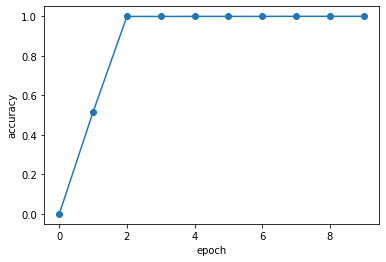

In [4]:
# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.show()

- Attention을 적용한 seq2seq모델이 baseline + peeky 모델보다 학습속도 면과 정확도 면에서 우세함 

## 어텐션 시각화

- 어텐션 계층은 각 시각의 어텐션 가중치를 인스턴스 변수로 보관하고 있음!
    - `attention_weights`
    
    
**학습된 모델을 사용하여 시계열 변환 수행했을 때의 어텐션 가중치 시각화**
- 가로축 : 입력 문장
- 세로축 : 출력 문장
- 맵의 각 원소는 밝을 수록 값이 크다

In [7]:
import sys
sys.path.append('..')
import numpy as np
from dataset import sequence
import matplotlib.pyplot as plt
from attention_seq2seq import AttentionSeq2seq


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()

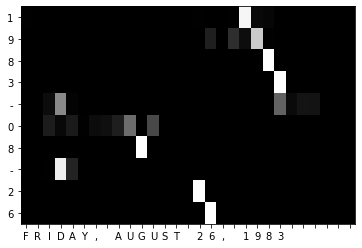

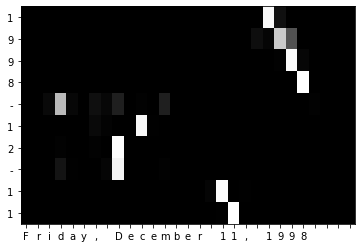

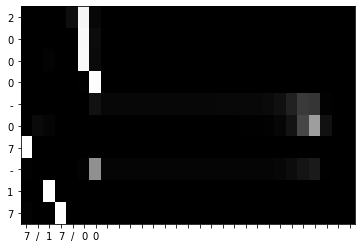

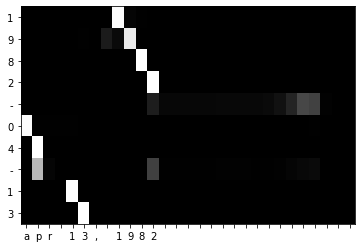

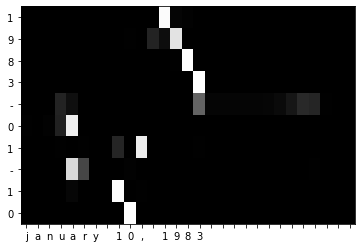

In [19]:
# 시드 고정
np.random.seed(1984) 
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)

    attention_map = d.reshape(d.shape[0], d.shape[2])

    # 출력하기 위해 반전
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)

# 어텐션에 관한 남은 이야기

## 양방향 RNN

===> 단어의 주변 정보를 균형있게 담을 수 있다!

<img src = "../imgs/fig 8-30.png" width="600">

- 각 단어에 대응하는 은닉 상태 벡터에는 **좌와 우 양쪽 방향으로부터 균형있게 정보를 인코딩!**

    - LSTM 계층 + 역방향 LSTM 계층
    - 두 LSTM 계층의 은닉 상태를 연결 시킨 벡터를 최종 은닉 상태로 처리


- LSTM 계층
    - 입력 문장 왼 ==> 오


- 역방향 LSTM 계층
    - 입력 문장 오 ==> 왼

In [20]:
class TimeBiLSTM:
    def __init__(self, Wx1, Wh1, b1,
                 Wx2, Wh2, b2, stateful=False):
        self.forward_lstm = TimeLSTM(Wx1, Wh1, b1, stateful)
        self.backward_lstm = TimeLSTM(Wx2, Wh2, b2, stateful)
        self.params = self.forward_lstm.params + self.backward_lstm.params
        self.grads = self.forward_lstm.grads + self.backward_lstm.grads

    def forward(self, xs):
        o1 = self.forward_lstm.forward(xs)
        o2 = self.backward_lstm.forward(xs[:, ::-1])
        o2 = o2[:, ::-1]

        out = np.concatenate((o1, o2), axis=2)
        return out

    def backward(self, dhs):
        H = dhs.shape[2] // 2
        do1 = dhs[:, :, :H]
        do2 = dhs[:, :, H:]

        dxs1 = self.forward_lstm.backward(do1)
        do2 = do2[:, ::-1]
        dxs2 = self.backward_lstm.backward(do2)
        dxs2 = dxs2[:, ::-1]
        dxs = dxs1 + dxs2
        return dxs

## Attention 계층 사용 방법

### 방법 1. - LSTM - Attention - Affine

<img src = "../imgs/fig 8-31.png" width="400" align='center'>

- Affine 계층이 맥락 벡터 이용
- 구현이 더 쉽다

### 방법 2. - LSTM - Attention - LSTM

<img src = "../imgs/fig 8-32.png" width="450" align='center'>

- LSTM 계층이 맥락 벡터 이용


## seq2seq 심층화와 skip 연결

<img src = "../imgs/fig 8-33.png" width="600" align='center'>

- Encoder와 Decoder 3층 LSTM 계층 사용

- **Encoder와 Decoder는 같은 층수의 LSTM 계층을 이용하는 것이 일반적임**    

---

- **층이 깊어질 수록 드롭아웃 혹은 가중치 공유 등의 기술 사용 권장**

- `skip connection` : **층을 깊게 할 때 사용되는 기법** 중 하나    
    - `residual connection` or `shot-chut`
    - <img src = "../imgs/fig 8-34.png" width="200" align='center'>
    - 계층을 건너뛰는 기법
        - 덧셈 연결부에 출력 2개가 더해진다 
        - 덧셈은 역전파 시 기울기를 그대로 흘려보내므로, 층이 깊어져도 기울기가 소실되지 않는다

# 어텐션 응용

## 구글 신경망 기계 번역 (Google Neural Machine Translation, GNMT)

<img src = "../imgs/fig 8-35.png" width="600" align='center'>

- LSTM 계층 다층화
- Encoder의 첫번째 계층만 양방향 LSTM 
- skip connection
- 다수 GPU로 분산 학습 (100개 gpu로 6일..)

==> 사람의 정확도에 근사함

## 트랜스포머

RNN은 이전 시각에 계산한 결과를 이용하여 순차적으로 계산하는 방식. 그러나 이러한 계산은 병렬 처리가 불가하다는 치명적인 단점이 있음. 이에 RNN을 없애는 연구 ( 병렬 계산할 수 있는 RNN 연구 ) 가 활발히 이뤄짐 그 중 하나가    

### *Attention is all you need* 에서 제안한 기법인 `Transformer` 모델

- RNN이 아닌 어텐션을 사용하여 처리
- **`Self-Attention` : 자기 자신에 대한 주목**
- **하나의 시계열 데이터 내에서** 각 원소가 다른 원소들과 어떻게 관련되는지를 보자.

<img src = "../imgs/fig 8-37.png" width="500" align='center'>

- 왼) 서로 다른 두 시계열 데이터가 입력됨
- 오) 두 입력이 하나의 시계열 데이터로부터 나온다
    - 하나의 시계열 데이터 내에서 원소 간 대응 관계 구함
    
---

<img src = "../imgs/fig 8-38.png" width="500" align='center'>

- Encoder와 Decoder 모두에서 RNN 대신 Attention 사용
    - 학습 시간 대폭 감소!
    - 병렬 처리 가능!
    - 정확도 향상!

## 뉴럴 튜링 머신 (Neural Turing Machine, NTM)

**외부 메모리**를 통해 RNN의 한정적인 정보 보관량(고정 길이) 을 늘리는 방식

<img src = "../imgs/fig 8-40.png" width="300" align='center'>

- 바깥에 메모리! ==> 중앙 컨트롤러 (RNN 신경망) 에게 컴퓨터 능력을 줌
    - 정보 쓰기 
    - 정보 지우기
    - 정보 읽기

---
<img src = "../imgs/fig 8-41.png" width="600" align='center'>


- **어텐션을 이용해** Write Head & Read Head 계층이 메모리 조작
- 읽고 쓰는 작업을 가중치로 대체하여..
- 2개의 어텐션 이용
    - 콘텐츠 기반 어텐션
        - 그냥 어텐션
        - query 벡터와 비슷한 벡터를 메모리에서 찾아내줌
    - 위치 기반 어텐션
        - 이전 시각에서 주목한 메모리의 위치 기준으로 단어 전후로 이동